In [1]:
import pandas as pd
import numpy as np
from datetime import date
import holidays
from prophet import Prophet

import datetime
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
state = np.random.RandomState(12345)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

df = pd.read_csv('sp_sales_task\\train_cluster.csv')


In [3]:
df.head()

,Unnamed: 0,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,month_year,price_units,price_pred,...,pr_group_id_group,year,month,week,day,holiday,liquidity,top_st_revenue,cluster_kmean,cluster_st
0,0,7,1541,2022-10-20,1,5,825,2022-10,165.0,0.006738,...,1,2022,10,3,20,0,1,0,270.0,3.0
1,1,3,779,2023-01-29,0,4,196,2023-01,49.0,0.018316,...,1,2023,1,6,29,1,1,0,26.0,2.0
2,2,2,240,2023-03-02,0,1,78,2023-03,78.0,0.367879,...,1,2023,3,3,2,0,1,0,337.0,3.0
3,3,1,1779,2023-02-17,0,1,161,2023-02,161.0,0.367879,...,1,2023,2,4,17,0,1,0,178.0,0.0
4,4,3,361,2022-11-03,0,3,123,2022-11,41.0,0.049787,...,1,2022,11,3,3,0,1,0,99.0,2.0


In [4]:
# df['fe_st_id'] = df['st_id'].map(df['st_id'].value_counts(normalize=False))
# df['fe_pr_sku_id'] = df['pr_sku_id'].map(df['pr_sku_id'].value_counts(normalize=False))
# df['fe_st_city_id'] = df['st_city_id'].map(df['st_city_id'].value_counts(normalize=False))
# df['fe_st_division_code'] = df['st_division_code'].map(df['st_division_code'].value_counts(normalize=False))
# df['fe_pr_group_id'] = df['pr_group_id'].map(df['pr_group_id'].value_counts(normalize=False))
# df['fe_pr_cat_id'] = df['pr_cat_id'].map(df['pr_cat_id'].value_counts(normalize=False))
# df['fe_pr_subcat_id'] = df['pr_subcat_id'].map(df['pr_subcat_id'].value_counts(normalize=False))

In [5]:
df = df.rename(columns = {'pr_sales_in_units' : 'y'})

In [6]:
df['ds'] = pd.to_datetime(df['date'])

In [7]:
# df = df.drop(['st_id', 'pr_sku_id', 'st_city_id',
#               'st_division_code', 'pr_group_id',
#                   'pr_cat_id', 'pr_subcat_id',
#                   'pr_promo_sales_in_units',
#                    'pr_promo_sales_in_rub', 'date'], axis=1)

In [8]:
df = df.drop(['date'], axis=1)

In [9]:
df.dropna (how='all')

,Unnamed: 0,st_id,pr_sku_id,pr_sales_type_id,y,pr_sales_in_rub,month_year,price_units,price_pred,price_units_log,...,year,month,week,day,holiday,liquidity,top_st_revenue,cluster_kmean,cluster_st,ds
0,0,7,1541,1,5,825,2022-10,165.00,0.006738,5.105945,...,2022,10,3,20,0,1,0,270.0,3.0,2022-10-20
1,1,3,779,0,4,196,2023-01,49.00,0.018316,3.891820,...,2023,1,6,29,1,1,0,26.0,2.0,2023-01-29
2,2,2,240,0,1,78,2023-03,78.00,0.367879,4.356709,...,2023,3,3,2,0,1,0,337.0,3.0,2023-03-02
3,3,1,1779,0,1,161,2023-02,161.00,0.367879,5.081404,...,2023,2,4,17,0,1,0,178.0,0.0,2023-02-17
4,4,3,361,0,3,123,2022-11,41.00,0.049787,3.713572,...,2022,11,3,3,0,1,0,99.0,2.0,2022-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790050,790050,7,1207,1,1,33,2022-12,33.00,0.367879,3.496508,...,2022,12,1,13,0,1,0,165.0,3.0,2022-12-13
790051,790051,3,656,0,1,192,2023-04,192.00,0.367879,5.257495,...,2023,4,1,18,0,1,0,85.0,2.0,2023-04-18
790052,790052,3,1551,0,5,970,2022-08,194.00,0.006738,5.267858,...,2022,8,1,16,0,1,0,12.0,2.0,2022-08-16
790053,790053,8,1422,0,4,262,2023-04,65.50,0.018316,4.182050,...,2023,4,6,23,1,1,0,130.0,4.0,2023-04-23


In [10]:
# Вкидываем праздники, для их учёта моделькой
holidays_dict = holidays.RUS(years=(2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.head(10)

,ds,holiday
0,2022-01-01,Новогодние каникулы
1,2022-01-02,Новогодние каникулы
2,2022-01-03,Новогодние каникулы
3,2022-01-04,Новогодние каникулы
4,2022-01-05,Новогодние каникулы
5,2022-01-06,Новогодние каникулы
6,2022-01-07,Рождество Христово
7,2022-01-08,Новогодние каникулы
8,2022-02-23,День защитника Отечества
9,2022-03-08,Международный женский день


In [28]:
# Период, который надо отрезать и предсказать (проверка модели)
date_lag = 3
predictions = df['ds'].max() - timedelta(date_lag)

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = df.loc[df['ds'] < predictions]

In [29]:
m = Prophet(holidays=df_holidays, daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
m.fit(train_df)

20:51:21 - cmdstanpy - INFO - Chain [1] start processing
20:51:54 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Предсказываем 15 дней
future = m.make_future_dataframe(periods=date_lag)
forecast = m.predict(future)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:71: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


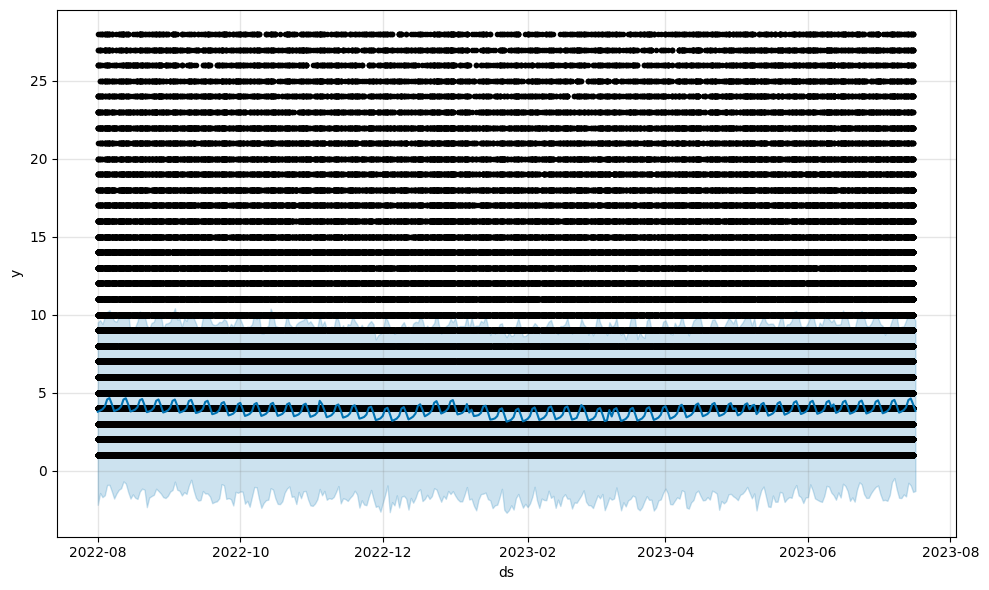

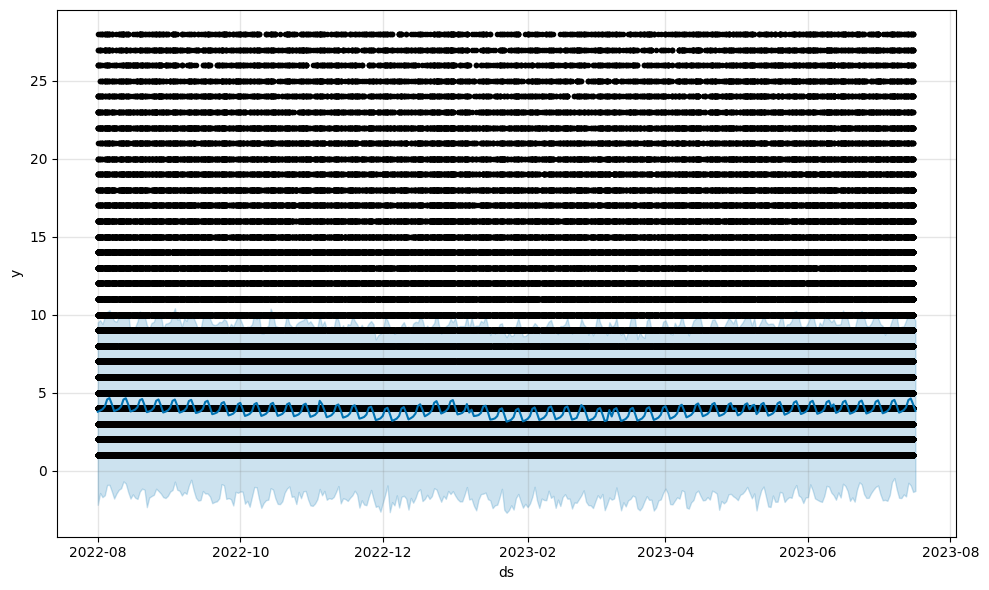

In [23]:
# Смотрим, что предсказалось
m.plot(forecast)

C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:226: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:349: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\14488\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Lo

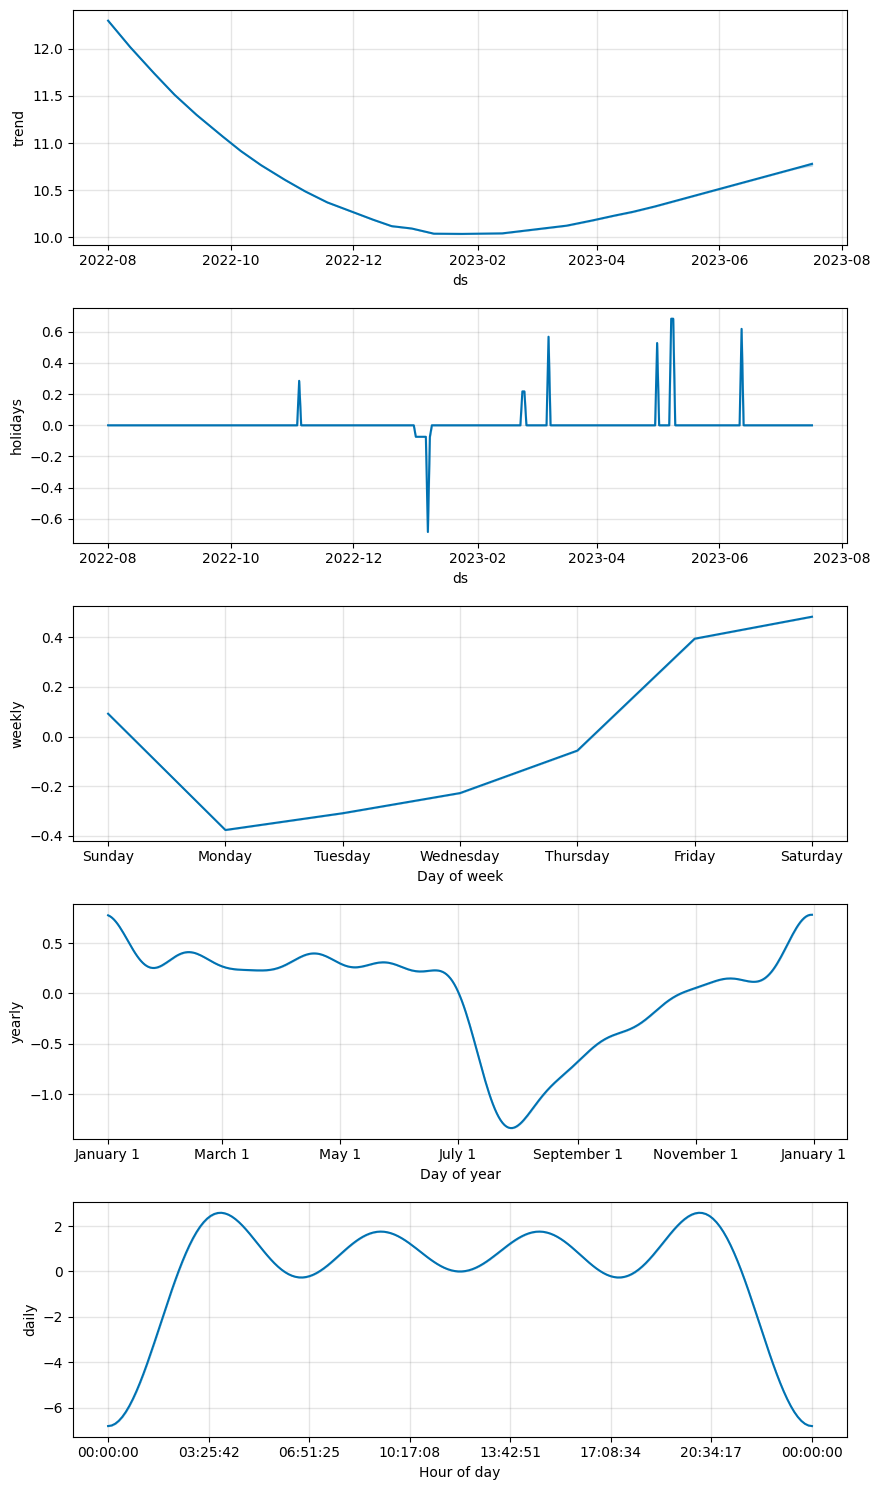

In [15]:
# Смотрим по компонентам
m.plot_components(forecast);

In [34]:
# Объединяем первоначальную таблицу и таблицу с признаками и таргетом
df_test = df.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

In [35]:
# Для вычисления метрики берем только отрезанную часть датасета
df_metric = df_test[df_test['ds'] > predictions]

In [36]:
# Вычисляем метрику
wape = 100 * (df_metric['y'] - df_metric['yhat']).abs().sum() / df_metric['y'].sum()
wape

51.7963194701625

In [43]:
df_test[['ds', 'st_id', 'yhat', 'y']].head(10)


,ds,st_id,yhat,y
0,2022-10-20,7,3.804143,5
1,2023-01-29,3,3.601815,4
2,2023-03-02,2,3.490694,1
3,2023-02-17,1,4.030386,1
4,2022-11-03,3,3.733290,3
5,2023-02-05,2,3.684512,2
6,2023-05-09,2,4.218492,1
7,2023-04-13,1,3.753485,1
8,2022-09-18,3,4.084793,2
9,2023-03-04,8,4.017381,2
